In [22]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys
sys.path.append("/n/home12/binxuwang/Github/mini_edm")
sys.path.append("/n/home12/binxuwang/Github/DiffusionReasoning")
import os
from os.path import join
import pickle as pkl
import einops
import torch
import torch as th
from easydict import EasyDict as edict
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from train_edm import create_model, edm_sampler, EDM
from edm_utils import edm_sampler_inpaint, create_edm, get_default_config, create_edm_new
from tqdm import trange, tqdm
# from rule_utils import get_rule_img, get_obj_list, get_rule_list
# from rule_utils import check_consistent
from dataset_utils import train_data2attr_tsr,load_raw_data,load_PGM_abstract
from rule_new_utils import infer_rule_from_sample_batch, check_r3_r2_batch
from stats_plot_utils import add_rectangles, saveallforms
plt.rcParams['figure.dpi'] = 72
plt.rcParams['figure.figsize'] = [6.0, 4.0]
plt.rcParams['figure.edgecolor'] = (1, 1, 1, 0)
plt.rcParams['figure.facecolor'] = (1, 1, 1, 0)
# vector graphics type
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42


In [24]:
heldout_id_dict = {
    'train_inputs_new.pt'       : [1, 16, 20, 34, 37], 
    'train_inputs_new_split0.pt': [1, 16, 20, 34, 37], 
    'train_inputs_new_split1.pt': [8, 12, 24, 36, 39],
    'train_inputs_new_split2.pt': [5, 17, 21, 33, 38],
    'train_inputs_new_split3.pt': [3, 10, 29, 31, 37],
    'train_inputs_new_split4.pt': [0, 14, 27, 35, 38],
    'train_inputs_new_split5.pt': [4, 19, 26, 30, 39],
    'train_inputs_new_split6.pt': [9, 13, 25, 32, 37],
    'train_inputs_new_split7.pt': [2, 18, 23, 30, 38],
    'train_inputs_new_split8.pt': [7, 15, 22, 34, 39],
    'train_inputs_new_split9.pt': [6, 11, 28, 33, 37],
}
heldout_ids = heldout_id_dict['train_inputs_new.pt']  # [1, 16, 20, 34, 37]

In [2]:
exproot = r"/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps"
# expname = "WideBlnrX3_new_RAVEN10_abstract_20240315-1327"
expname = "WideBlnrX3_new_RAVEN10_abstract_20240412-1347"
epoch = 999999 #700000
device = "cuda"

DATASET = "RAVEN10_abstract"
expdir = join(exproot, expname)
ckptdir = join(expdir, "checkpoints")
savedir = join(expdir, "inpaint_pilot")
os.makedirs(savedir, exist_ok=True)

config_ft = get_default_config(DATASET, layers_per_block=2, 
                               model_channels=128, 
                               channel_mult=[1, 2, 4], 
                               attn_resolutions=[9, 3], 
                               spatial_matching="bilinear")
ckpt_path = join(ckptdir, f"ema_{epoch}.pth")
edm, model_EDM = create_edm_new(ckpt_path, config_ft, device) 


In [3]:
!ls {savedir}

inpaint_meta_col_Heun18.pkl		inpaint_rule_stats_Heun35.csv
inpaint_meta_col.pkl			inpaint_rule_stats_unif_baseline.csv
inpaint_meta_col_unif_baseline.pkl	inpaint_sample_col_Heun18.pkl
inpaint_rule_all_col_Heun18.pkl		inpaint_sample_col.pkl
inpaint_rule_all_col.pkl		inpaint_sample_col_unif_baseline.pkl
inpaint_rule_all_col_unif_baseline.pkl	inpaint_stats_col_Heun18.pkl
inpaint_rule_stats.csv			inpaint_stats_col.pkl
inpaint_rule_stats_Heun18.csv		inpaint_stats_col_unif_baseline.pkl


In [6]:
!stat {savedir}/*.csv

  File: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240412-1347/inpaint_pilot/inpaint_rule_stats.csv
  Size: 55918     	Blocks: 112        IO Block: 4194304 regular file
Device: 865a45f8h/2254063096d	Inode: 144115458323254321  Links: 1
Access: (0664/-rw-rw-r--)  Uid: (64173/binxuwang)   Gid: (11168/kempner_fellow_binxuwang)
Context: unconfined_u:object_r:unlabeled_t:s0
Access: 2024-04-15 19:38:26.000000000 -0400
Modify: 2024-04-15 17:32:40.000000000 -0400
Change: 2024-04-15 17:32:40.000000000 -0400
 Birth: 2024-04-15 17:03:52.000000000 -0400
  File: /n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/mini_edm/exps/WideBlnrX3_new_RAVEN10_abstract_20240412-1347/inpaint_pilot/inpaint_rule_stats_Heun18.csv
  Size: 564184    	Blocks: 1104       IO Block: 4194304 regular file
Device: 865a45f8h/2254063096d	Inode: 144115469161335059  Links: 1
Access: (0664/-rw-rw-r--)  Uid: (64173/binxuwang)   Gid: (1

In [9]:
suffix = "_Heun18"
df = pd.read_csv(join(savedir, f"inpaint_rule_stats{suffix}.csv"), index_col=0)

In [13]:
mean_consist = df.groupby("iclass").agg({"consistent_r3": "mean",})
mean_consist_vec = mean_consist.values

In [26]:
df.consistent_r3.mean()

22.876666666666665

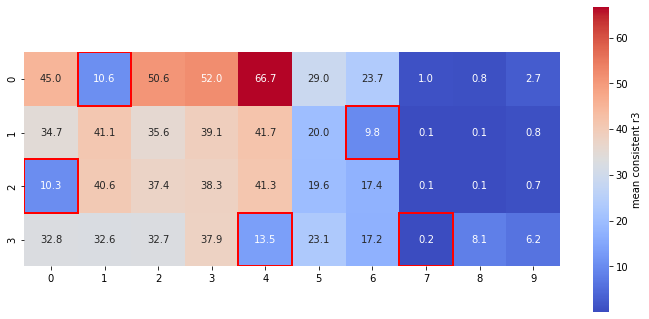

In [25]:
plt.figure(figsize=(12, 5.5))
sns.heatmap(mean_consist_vec.reshape(-1, 10), cmap="coolwarm", 
            annot=True, fmt=".1f", 
            cbar_kws={'label': 'mean consistent r3'})
plt.axis("image")
add_rectangles(heldout_ids)
plt.show()